# Análise Final La Msion Brasil

## Bibliotecas

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


## Carregando os dados

In [2]:
df_completo = pd.read_csv("df_completo_final.csv", sep=",")
df_completo.head(10)

,Nome Atleta,sexo,faixa_etaria,peso,ano,km_prova,tempo_por_km_seg,ano_mais_antigo,desnivel_positivo,desnivel_negativo
0,André Mapa,Homens,35 a 44,Não informado,2023,1.0,285,2023,13.0,-9.0
1,André Mapa,Homens,35 a 44,Não informado,2023,2.0,298,2023,88.0,0.0
2,André Mapa,Homens,35 a 44,Não informado,2023,3.0,295,2023,58.0,0.0
3,André Mapa,Homens,35 a 44,Não informado,2023,4.0,363,2023,46.0,-81.0
4,André Mapa,Homens,35 a 44,Não informado,2023,5.0,357,2023,41.0,-58.0
5,André Mapa,Homens,35 a 44,Não informado,2023,6.0,670,2023,128.0,-11.0
6,André Mapa,Homens,35 a 44,Não informado,2023,7.0,258,2023,228.0,-7.0
7,André Mapa,Homens,35 a 44,Não informado,2023,8.0,211,2023,1.0,-243.0
8,André Mapa,Homens,35 a 44,Não informado,2023,9.0,338,2023,1.0,-122.0
9,André Mapa,Homens,35 a 44,Não informado,2023,10.0,544,2023,9.0,-69.0


In [3]:
df_completo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3894 entries, 0 to 3893
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Nome Atleta        3894 non-null   object 
 1   sexo               3894 non-null   object 
 2   faixa_etaria       3894 non-null   object 
 3   peso               3894 non-null   object 
 4   ano                3894 non-null   int64  
 5   km_prova           3894 non-null   float64
 6   tempo_por_km_seg   3894 non-null   int64  
 7   ano_mais_antigo    3894 non-null   int64  
 8   desnivel_positivo  3881 non-null   float64
 9   desnivel_negativo  3881 non-null   float64
dtypes: float64(3), int64(3), object(4)
memory usage: 304.3+ KB


## Análise Exploratória dos dados

Vamos começar analisando o desempenho geral dos atletas. Para isso devemos trasnformar nosso dataframe onde cada linha é um km do atleta, para um novo onde cada linha dever uma única observação do atleta e as variáveis vão ser um resumo.

In [4]:
df_agregado_por_atleta = (
    df_completo.groupby("Nome Atleta")
    .agg(
        # Pega a informação demográfica (que é a mesma em todas as linhas do atleta)
        sexo=("sexo", "first"),
        faixa_etaria=("faixa_etaria", "first"),
        peso=("peso", "first"),
        ano_corrida=("ano", "first"),  # Pega o ano da corrida
        # Calcula as métricas de desempenho e estratégia
        Tempo_Final_seg=("tempo_por_km_seg", "sum"),
        Ritmo_Medio_seg=("tempo_por_km_seg", "mean"),
        Variabilidade_Ritmo_std=(
            "tempo_por_km_seg",
            "std",
        ),  # Desvio padrão do ritmo por km
        # Calcula as métricas de esforço relacionadas ao percurso
        Total_Desnivel_Positivo=("desnivel_positivo", "sum"),
        Total_Desnivel_negativo=("desnivel_negativo", "sum"),
    )
    .reset_index()
)

# Para facilitar a interpretação, vamos converter segundos para minutos
df_agregado_por_atleta["Tempo_Final_min"] = (
    df_agregado_por_atleta["Tempo_Final_seg"] / 60
)
df_agregado_por_atleta["Ritmo_Medio_min"] = (
    df_agregado_por_atleta["Ritmo_Medio_seg"] / 60
)
df_agregado_por_atleta["Variabilidade_Ritmo_min_std"] = (
    df_agregado_por_atleta["Variabilidade_Ritmo_std"] / 60
)

# Vamos ver como ficou
df_agregado_por_atleta.head()

,Nome Atleta,sexo,faixa_etaria,peso,ano_corrida,Tempo_Final_seg,Ritmo_Medio_seg,Variabilidade_Ritmo_std,Total_Desnivel_Positivo,Total_Desnivel_negativo,Tempo_Final_min,Ritmo_Medio_min,Variabilidade_Ritmo_min_std
0,ALFREDO GUIMARAES,Homens,45 a 54,75 a 84 kg,2022,21774,604.833333,290.291331,2787.0,-2790.0,362.900000,10.080556,4.838189
1,Albert Melo,Homens,25 a 34,75 a 84 kg,2022,31986,888.500000,417.596832,2787.0,-2790.0,533.100000,14.808333,6.959947
2,Alessandro Sousa(allê),Homens,45 a 54,65 a 74 kg,2023,33826,939.611111,669.719569,2787.0,-2790.0,563.766667,15.660185,11.161993
3,Alex Junior Aj,Homens,20 a 24,65 a 74 kg,2022,18496,513.777778,261.647539,2787.0,-2790.0,308.266667,8.562963,4.360792
4,Alexandre Santiago,Homens,35 a 44,55 a 64 kg,2022,14894,413.722222,194.192778,2779.0,-2781.0,248.233333,6.895370,3.236546


### Análises gráficas

#### Dstribuição do tempo final

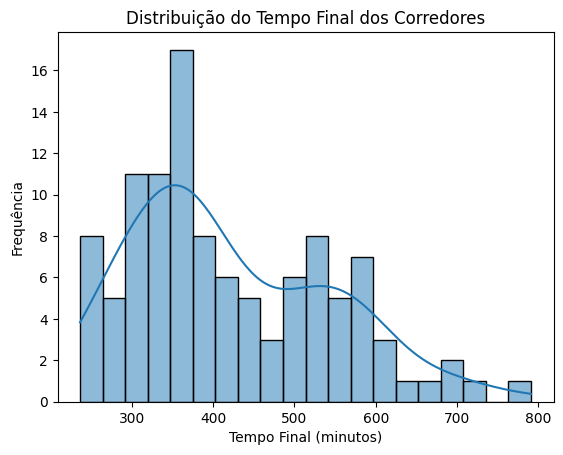

count    109.000000
mean     422.824771
std      123.184123
min      236.400000
25%      329.000000
50%      389.816667
75%      525.333333
max      790.933333
Name: Tempo_Final_min, dtype: float64


In [5]:
sns.histplot(data=df_agregado_por_atleta, x="Tempo_Final_min", bins=20, kde=True)
plt.title("Distribuição do Tempo Final dos Corredores")
plt.xlabel("Tempo Final (minutos)")
plt.ylabel("Frequência")
plt.show()

# Também é útil ver as estatísticas descritivas
print(df_agregado_por_atleta["Tempo_Final_min"].describe())

#### Análise do Sexo

In [6]:
df_agregado_por_atleta["sexo"].value_counts()

sexo
Homens      78
Mulheres    31
Name: count, dtype: int64

- Aqui podemos observar a que a quantidade de participantes homens é maior que a participação de mulheres.

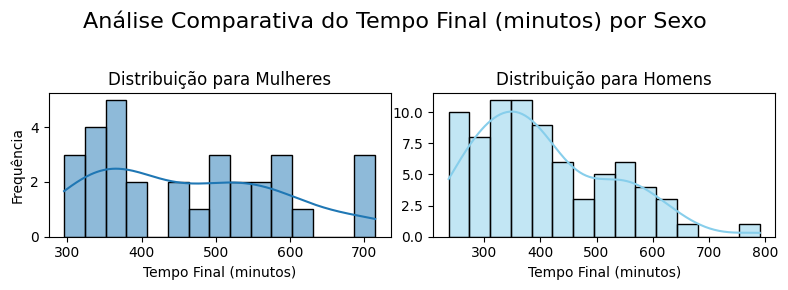

--- Estatísticas Descritivas Comparativas ---
       Mulheres  Homens
count     31.00   78.00
mean     465.33  405.93
std      124.03  119.47
min      295.48  236.40
25%      361.98  314.38
50%      444.90  374.14
75%      557.38  497.89
max      714.43  790.93


In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

# Título principal para a figura inteira
fig.suptitle("Análise Comparativa do Tempo Final (minutos) por Sexo", fontsize=16)


# 2. Plote o histograma das Mulheres no primeiro eixo (axes[0])
sns.histplot(
    data=df_agregado_por_atleta[df_agregado_por_atleta["sexo"] == "Mulheres"],
    x="Tempo_Final_min",
    bins=15,
    kde=True,
    ax=axes[0],
)  # A chave é especificar o eixo aqui!
axes[0].set_title("Distribuição para Mulheres")
axes[0].set_xlabel("Tempo Final (minutos)")
axes[0].set_ylabel("Frequência")


# 3. Plote o histograma dos Homens no segundo eixo (axes[1])
sns.histplot(
    data=df_agregado_por_atleta[df_agregado_por_atleta["sexo"] == "Homens"],
    x="Tempo_Final_min",
    bins=15,
    kde=True,
    color="skyblue",  # Mudar a cor ajuda na diferenciação
    ax=axes[1],
)  # E aqui também!
axes[1].set_title("Distribuição para Homens")
axes[1].set_xlabel("Tempo Final (minutos)")
axes[1].set_ylabel("")  # Pode remover o label do eixo Y para um visual mais limpo


# 4. Exiba os gráficos
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajusta o layout para evitar sobreposição
plt.show()


# ======================================================================
# PARTE 2: ESTATÍSTICAS (.DESCRIBE()) LADO A LADO
# ======================================================================

# 1. Calcule o describe() para cada grupo separadamente
desc_mulheres = df_agregado_por_atleta[df_agregado_por_atleta["sexo"] == "Mulheres"][
    "Tempo_Final_min"
].describe()
desc_homens = df_agregado_por_atleta[df_agregado_por_atleta["sexo"] == "Homens"][
    "Tempo_Final_min"
].describe()


# 2. Use pd.concat para unir as duas saídas como colunas de um novo DataFrame
# axis=1 indica que a concatenação deve ser feita pelas colunas (lado a lado).
# keys=[] define os nomes das novas colunas.
estatisticas_comparativas = pd.concat(
    [desc_mulheres, desc_homens], axis=1, keys=["Mulheres", "Homens"]
)


# 3. Imprima a tabela comparativa final
print("--- Estatísticas Descritivas Comparativas ---")
print(
    estatisticas_comparativas.round(2)
)  # .round(2) para formatar com 2 casas decimais


In [8]:
estatisticas_describe = ["count", "mean", "std", "min", "median", "max"]

# 2. Crie o dicionário de agregação, passando a lista de estatísticas para cada coluna
resumo_completo = (
    df_agregado_por_atleta.groupby("sexo")
    .agg(
        {
            "Tempo_Final_min": estatisticas_describe,
            "Ritmo_Medio_min": estatisticas_describe,
            "Variabilidade_Ritmo_min_std": estatisticas_describe,
        }
    )
    .stack(level=0)
)

# 3. Imprima o resultado. Usar .round(2) ajuda na visualização.
print("--- Resumo Estatístico Detalhado por Sexo ---")
print(resumo_completo.round(2))

--- Resumo Estatístico Detalhado por Sexo ---
                                      count    mean     std     min  median  \
sexo                                                                          
Homens   Ritmo_Medio_min                 78   11.36    3.38    6.57   10.39   
         Tempo_Final_min                 78  405.93  119.47  236.40  374.14   
         Variabilidade_Ritmo_min_std     78    6.63    3.08    2.90    5.13   
Mulheres Ritmo_Medio_min                 31   13.07    3.56    8.21   12.36   
         Tempo_Final_min                 31  465.33  124.03  295.48  444.90   
         Variabilidade_Ritmo_min_std     31    7.98    3.55    3.90    7.11   

                                         max  
sexo                                          
Homens   Ritmo_Medio_min               22.60  
         Tempo_Final_min              790.93  
         Variabilidade_Ritmo_min_std   16.40  
Mulheres Ritmo_Medio_min               20.41  
         Tempo_Final_min              7

C:\Users\Home\AppData\Local\Temp\ipykernel_9928\3671722932.py:13: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(level=0)


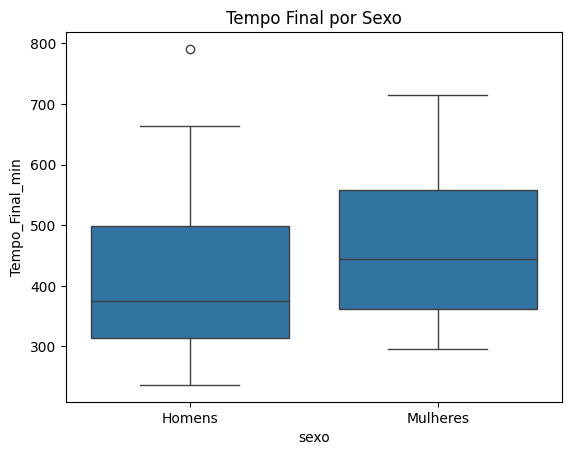

In [9]:
# Sexo vs. Tempo Final
sns.boxplot(data=df_agregado_por_atleta, x="sexo", y="Tempo_Final_min")
plt.title("Tempo Final por Sexo")
plt.show()


1. Tempo Final da Prova (Tempo_Final_min)

Desempenho Médio: Os homens terminaram a prova, em média, cerca de 1 hora mais rápido que as mulheres (mean de 406 min para homens vs. 465 min para mulheres). A mediana (o valor do meio) confirma essa tendência, mostrando que o corredor "mediano" masculino também foi consideravelmente mais rápido.

Dispersão: A dispersão dos tempos é alta e relativamente parecida para ambos os grupos (std de 119 min para homens e 124 min para mulheres). Isso indica que, em ambos os sexos, havia uma grande variedade de níveis de habilidade, desde os corredores mais rápidos até os que levaram mais tempo. Podendo existir níveis entre os corredores, indo de corredores mais experientes e profissionais ate corredores amadores e menos experientes.

2. Ritmo Médio (Ritmo_Medio_min)

Velocidade Média: Confirmando o dado anterior, o ritmo médio dos homens foi mais baixo (mais rápido), com uma média de 11.36 min/km contra 13.07 min/km das mulheres.

Melhores e Piores Ritmos: O homem mais rápido teve um ritmo de 6.57 min/km, enquanto a mulher mais rápida teve um ritmo de 8.21 min/km. Ambos os grupos tiveram atletas com ritmos bem mais lentos (22.60 e 20.41 min/km), o que é comum em corridas de montanha devido à dificuldade do percurso.

3. Variabilidade do Ritmo (Variabilidade_Ritmo_min_std)

Consistência da Prova: Esta é talvez a métrica mais interessante. Em média, os homens tiveram uma menor variabilidade de ritmo (mean de 6.63) em comparação com as mulheres (mean de 7.98).

#### Análise por Faixa etária

In [19]:
df_agregado_por_atleta["faixa_etaria"].value_counts() / len(df_agregado_por_atleta)

faixa_etaria
35 a 44    0.412844
25 a 34    0.311927
45 a 54    0.183486
20 a 24    0.055046
55 a 64    0.036697
Name: count, dtype: float64

- Aqui podemos notar uma grande concetração em corredores de 35 a 44 anos, seguindo de corredores mais jovens de 25 a 34 anos. Temos um acumo de 90% dos participantes indo de 25 a 55 anos.

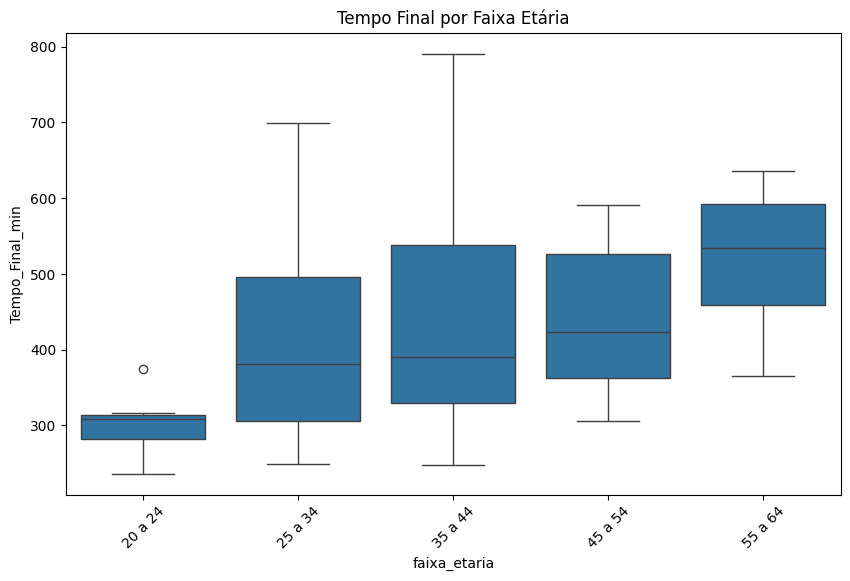

In [11]:
# Faixa Etária vs. Tempo Final
plt.figure(figsize=(10, 6))  # Aumenta o tamanho da figura para caber as labels
# Remove None values before sorting to avoid TypeError
faixa_etaria_order = sorted(
    [x for x in df_agregado_por_atleta["faixa_etaria"].unique() if x is not None]
)
sns.boxplot(
    data=df_agregado_por_atleta,
    x="faixa_etaria",
    y="Tempo_Final_min",
    order=faixa_etaria_order,
)
plt.title("Tempo Final por Faixa Etária")
plt.xticks(rotation=45)  # Rotaciona as labels do eixo x para não sobrepor
plt.show()

- Tendência Geral: O gráfico evidencia uma tendência geral de aumento do tempo mediano de conclusão da prova com o avanço da idade. Contudo, essa relação não se mostra perfeitamente linear.

- Melhor Desempenho: A faixa etária de 20 a 24 anos se destaca com o menor tempo mediano e a menor dispersão (caixa mais compacta). Isso sugere que este grupo não só foi o mais rápido, em média, mas também o mais homogêneo em termos de performance.

- Maior Variabilidade: O grupo de 35 a 44 anos apresenta a maior amplitude interquartil (a "altura" da caixa), indicando a maior variabilidade nos tempos de conclusão. Isso pode sugerir que esta faixa contém uma mistura mais heterogênea de atletas, desde os muito experientes até os iniciantes.

- Ponto de Inflexão: Nota-se um ponto de interesse na faixa de 45 a 54 anos, que apresenta um tempo mediano ligeiramente inferior ao do grupo anterior (35 a 44 anos). Isso quebra a tendência de queda de performance e pode ser um ponto a ser investigado futuramente.

- Outlier: É importante destacar a presença de um outlier no grupo de 20 a 24 anos, indicando um atleta com um tempo de prova atipicamente superior ao de seus pares na mesma faixa etária.

#### Análise por faixa de peso

In [12]:
df_agregado_por_atleta["peso"].value_counts()

peso
65 a 74 kg        34
75 a 84 kg        25
55 a 64 kg        21
54 kg e abaixo    12
Não informado      8
85 a 94 kg         7
95 kg a 104 kg     2
Name: count, dtype: int64

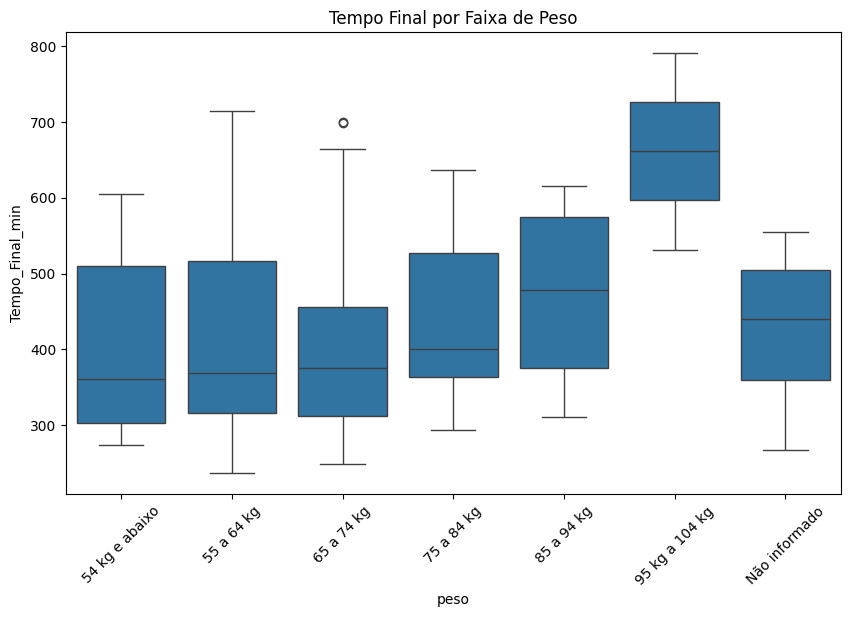

In [13]:
# Peso vs. Tempo Final
plt.figure(figsize=(10, 6))
# Remove None values before sorting to avoid TypeError
peso_order = sorted(
    [x for x in df_agregado_por_atleta["peso"].unique() if x is not None]
)
sns.boxplot(
    data=df_agregado_por_atleta, x="peso", y="Tempo_Final_min", order=peso_order
)
plt.title("Tempo Final por Faixa de Peso")
plt.xticks(rotation=45)
plt.show()

- Tendência Principal: Fica clara a correlação entre o aumento da faixa de peso e o aumento no tempo mediano de prova. Atletas mais leves tenderam a ser mais rápidos.

- Desempenho nos Extremos: O grupo de 54 kg e abaixo obteve os melhores tempos, enquanto a faixa de 95 a 104 kg registrou o desempenho médio mais lento.

- Variabilidade: As faixas de peso intermediárias (55 a 74 kg) mostram a maior dispersão nos resultado, indicando uma grande variação de performance nesses grupos.

- Dados não informados: O grupo "Não informado" apresenta um desempenho mediano, posicionando-se de forma similar às categorias de peso intermediárias.

#### Análise da Variabilidade de Ritmo

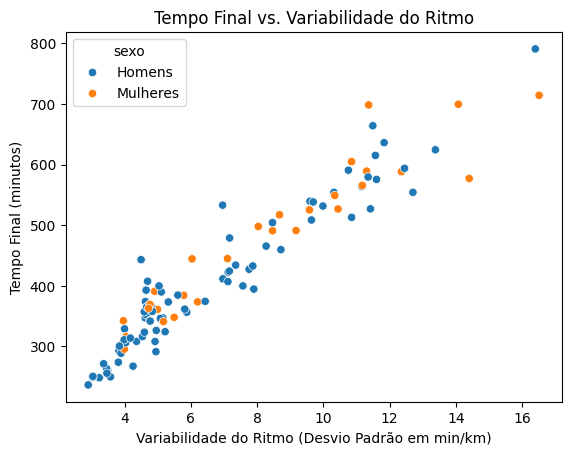

In [14]:
sns.scatterplot(
    data=df_agregado_por_atleta,
    x="Variabilidade_Ritmo_min_std",
    y="Tempo_Final_min",
    hue="sexo",
)
plt.title("Tempo Final vs. Variabilidade do Ritmo")
plt.xlabel("Variabilidade do Ritmo (Desvio Padrão em min/km)")
plt.ylabel("Tempo Final (minutos)")
plt.show()

- Correlação Positiva Evidente: O gráfico mostra uma clara e forte correlação positiva entre as duas variáveis. Isso significa que, à medida que a variabilidade do ritmo aumenta (eixo X), o tempo final da prova também tende a aumentar (eixo Y).

- Interpretação Prática: Em termos simples, os atletas que mantiveram um ritmo mais constante e com menos oscilações foram, em geral, os que terminaram a prova mais rápido. A consistência no ritmo parece ser um indicador chave para um bom desempenho.

- Comparativo entre Sexos: Ambos os grupos, homens e mulheres, seguem a mesma tendência linear. Não há uma separação clara dos grupos, indicando que essa relação entre consistência e performance é válida para ambos. No entanto, é possível notar que os pontos com o melhor desempenho combinado (canto inferior esquerdo, com baixo tempo e baixa variabilidade) são, em sua maioria, de atletas masculinos.

- Conclusão: A consistência do ritmo é um fator crucial para o desempenho nesta prova. Atletas menos eficientes em manter um passo estável, provavelmente devido ao terreno ou à estratégia, acabaram com tempos de conclusão significativamente mais altos.

#### Análise Metade da Prova

Vamos analisar o tempo médio entre primeira metade e segunda metade da prova.

- (Split Positivo): Significa que o ritmo na segunda metade foi mais alto (mais lento)
- (Split Negativo): Seria o caso de um atleta que correu a segunda metade mais rápido que a primeira.

In [22]:
df_metade = df_completo.copy()
df_metade["Metade_Prova"] = "Primeira Metade"
df_metade.loc[df_metade["km_prova"] > 18.0, "Metade_Prova"] = "Segunda Metade"
df_metade.head(5)

,Nome Atleta,sexo,faixa_etaria,peso,ano,km_prova,tempo_por_km_seg,ano_mais_antigo,desnivel_positivo,desnivel_negativo,Metade_Prova
0,André Mapa,Homens,35 a 44,Não informado,2023,1.0,285,2023,13.0,-9.0,Primeira Metade
1,André Mapa,Homens,35 a 44,Não informado,2023,2.0,298,2023,88.0,0.0,Primeira Metade
2,André Mapa,Homens,35 a 44,Não informado,2023,3.0,295,2023,58.0,0.0,Primeira Metade
3,André Mapa,Homens,35 a 44,Não informado,2023,4.0,363,2023,46.0,-81.0,Primeira Metade
4,André Mapa,Homens,35 a 44,Não informado,2023,5.0,357,2023,41.0,-58.0,Primeira Metade


In [ ]:
ritmo_por_metade = df_metade.groupby(["Nome Atleta", "Metade_Prova"]).agg(
    tempo_por_km_seg=("tempo_por_km_seg", "mean"),
    tempo_total=("tempo_por_km_seg", "sum"),
)
comparativo_splits = ritmo_por_metade.unstack()
multi_level_columns = comparativo_splits.columns
novos_nomes_colunas = [
    f"Ritmo_Medio_{metade.replace(' ', '_')}"
    if metrica == "tempo_por_km_seg"
    else f"Tempo_Total_{metade.replace(' ', '_')}"
    for metrica, metade in multi_level_columns
]

# 3. Atribua os novos nomes ao seu DataFrame
comparativo_splits_flat = comparativo_splits.copy()  # Copia para não alterar o original
comparativo_splits_flat.columns = novos_nomes_colunas

colunas_em_segundos = [
    "Ritmo_Medio_Primeira_Metade",
    "Ritmo_Medio_Segunda_Metade",
    "Tempo_Total_Primeira_Metade",
    "Tempo_Total_Segunda_Metade",
]
for coluna in colunas_em_segundos:
    # 3. Defina o nome da nova coluna, adicionando '_min' ao final
    nova_coluna_min = coluna + "_min"

    # 4. Crie a nova coluna, fazendo a conversão (dividir por 60) e arredondando (round(2))
    comparativo_splits_flat[nova_coluna_min] = (
        comparativo_splits_flat[coluna] / 60
    ).round(2)


comparativo_splits_flat["Diferenca_Media_Seg_Menos_Pri"] = (
    comparativo_splits_flat["Ritmo_Medio_Segunda_Metade_min"]
    - comparativo_splits_flat["Ritmo_Medio_Primeira_Metade_min"]
).round(2)
comparativo_splits_flat["Diferenca_total_Seg_Menos_Pri"] = (
    comparativo_splits_flat["Tempo_Total_Segunda_Metade_min"]
    - comparativo_splits_flat["Tempo_Total_Primeira_Metade_min"]
).round(2)
comparativo_splits_flat.head(5)

,Ritmo_Medio_Primeira_Metade,Ritmo_Medio_Segunda_Metade,Tempo_Total_Primeira_Metade,Tempo_Total_Segunda_Metade,Ritmo_Medio_Primeira_Metade_min,Ritmo_Medio_Segunda_Metade_min,Tempo_Total_Primeira_Metade_min,Tempo_Total_Segunda_Metade_min,Diferenca_Media_Seg_Menos_Pri,Diferenca_total_Seg_Menos_Pri
Nome Atleta,,,,,,,,,,
ALFREDO GUIMARAES,667.777778,541.888889,12020,9754,11.13,9.03,200.33,162.57,-2.10,-37.76
Albert Melo,942.944444,834.055556,16973,15013,15.72,13.90,282.88,250.22,-1.82,-32.66
Alessandro Sousa(allê),945.388889,933.833333,17017,16809,15.76,15.56,283.62,280.15,-0.20,-3.47
Alex Junior Aj,598.944444,428.611111,10781,7715,9.98,7.14,179.68,128.58,-2.84,-51.10
Alexandre Santiago,457.210526,365.117647,8687,6207,7.62,6.09,144.78,103.45,-1.53,-41.33
Alexandre Zolio,997.388889,850.000000,17953,15300,16.62,14.17,299.22,255.00,-2.45,-44.22
Anamaria Bacci,1120.277778,890.647059,20165,15141,18.67,14.84,336.08,252.35,-3.83,-83.73
André Mapa,493.444444,421.058824,8882,7158,8.22,7.02,148.03,119.30,-1.20,-28.73
Arnaldo Junio Rocha Pinho,539.833333,436.222222,9717,7852,9.00,7.27,161.95,130.87,-1.73,-31.08


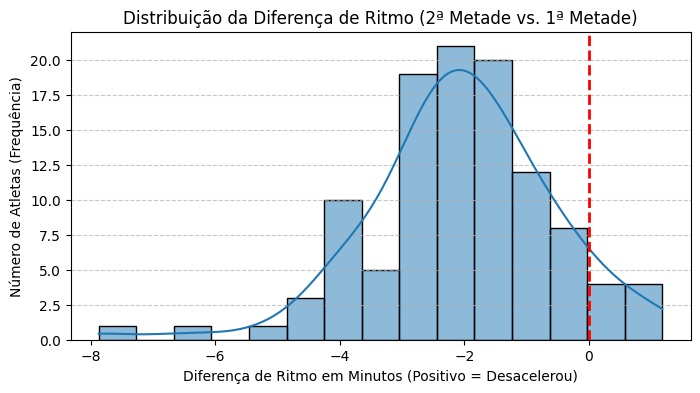

In [51]:
plt.figure(figsize=(8, 4))
sns.histplot(
    data=comparativo_splits_flat, x="Diferenca_Media_Seg_Menos_Pri", kde=True, bins=15
)

# Adiciona uma linha vertical em x=0 para ser nossa referência
# À esquerda da linha: atletas que aceleraram (split negativo)
# À direita da linha: atletas que desaceleraram (split positivo)
plt.axvline(x=0, color="red", linestyle="--", linewidth=2)

plt.title("Distribuição da Diferença de Ritmo (2ª Metade vs. 1ª Metade)")
plt.xlabel("Diferença de Ritmo em Minutos (Positivo = Desacelerou)")
plt.ylabel("Número de Atletas (Frequência)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

A análise da distribuição da diferença de ritmo entre a primeira e a segunda metade da prova (gráfico de histograma) revelou um insight fundamental sobre a natureza da competição. Observou-se que a grande maioria dos atletas concluintes apresentou um "split negativo", ou seja, um ritmo médio mais rápido na segunda metade do percurso.

Este padrão, evidenciado pelo pico da distribuição em valores negativos (-2 a -3 min/km), não deve ser interpretado primariamente como uma escolha estratégica deliberada dos atletas. A causa raiz mais provável é o perfil altimétrico do percurso, com uma concentração de subidas e maior dificuldade na primeira metade.

Dessa forma, a variável Diferenca_Seg_Menos_Pri transcende a simples noção de estratégia e se torna um índice de gestão de prova e de eficiência do atleta. Ela quantifica a capacidade de cada indivíduo de administrar seu esforço na seção mais exigente para, então, capitalizar no trecho teoricamente mais favorável. Uma diferença mais negativa pode indicar uma gestão de energia superior. Portanto, esta variável é considerada relevante e será incorporada em análises subsequentes para investigar sua correlação com o desempenho geral e outras métricas dos atletas.

In [52]:
# Vamos unir as duas tabelas
df_final_completo = pd.merge(
    left=df_agregado_por_atleta,  # A tabela principal, da esquerda
    right=comparativo_splits_flat,  # A tabela com os splits, da direita
    left_on="Nome Atleta",  # A chave na tabela da esquerda é a COLUNA 'Nome Atleta'
    right_index=True,  # A chave na tabela da direita é o ÍNDICE (que também é o nome do atleta)
    how="left",  # 'how=left' garante que todos os atletas da tabela principal sejam mantidos
)

df_final_completo.head()

,Nome Atleta,sexo,faixa_etaria,peso,ano_corrida,Tempo_Final_seg,Ritmo_Medio_seg,Variabilidade_Ritmo_std,Total_Desnivel_Positivo,Total_Desnivel_negativo,...,Ritmo_Medio_Primeira_Metade,Ritmo_Medio_Segunda_Metade,Tempo_Total_Primeira_Metade,Tempo_Total_Segunda_Metade,Ritmo_Medio_Primeira_Metade_min,Ritmo_Medio_Segunda_Metade_min,Tempo_Total_Primeira_Metade_min,Tempo_Total_Segunda_Metade_min,Diferenca_Media_Seg_Menos_Pri,Diferenca_total_Seg_Menos_Pri
0,ALFREDO GUIMARAES,Homens,45 a 54,75 a 84 kg,2022,21774,604.833333,290.291331,2787.0,-2790.0,...,667.777778,541.888889,12020,9754,11.13,9.03,200.33,162.57,-2.10,-37.76
1,Albert Melo,Homens,25 a 34,75 a 84 kg,2022,31986,888.500000,417.596832,2787.0,-2790.0,...,942.944444,834.055556,16973,15013,15.72,13.90,282.88,250.22,-1.82,-32.66
2,Alessandro Sousa(allê),Homens,45 a 54,65 a 74 kg,2023,33826,939.611111,669.719569,2787.0,-2790.0,...,945.388889,933.833333,17017,16809,15.76,15.56,283.62,280.15,-0.20,-3.47
3,Alex Junior Aj,Homens,20 a 24,65 a 74 kg,2022,18496,513.777778,261.647539,2787.0,-2790.0,...,598.944444,428.611111,10781,7715,9.98,7.14,179.68,128.58,-2.84,-51.10
4,Alexandre Santiago,Homens,35 a 44,55 a 64 kg,2022,14894,413.722222,194.192778,2779.0,-2781.0,...,457.210526,365.117647,8687,6207,7.62,6.09,144.78,103.45,-1.53,-41.33


In [58]:
df_final_completo.to_csv("df_agregado_por_atleta.csv", sep=";")

##### Analise tempo de prova x Diferença entre primeira e segunda parte da prova.

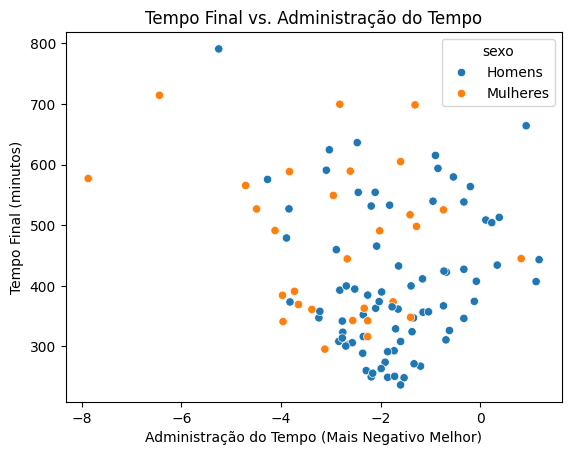

In [53]:
sns.scatterplot(
    data=df_final_completo,
    x="Diferenca_Media_Seg_Menos_Pri",
    y="Tempo_Final_min",
    hue="sexo",
)
plt.title("Tempo Final vs. Administração do Tempo")
plt.xlabel("Administração do Tempo (Mais Negativo Melhor)")
plt.ylabel("Tempo Final (minutos)")
plt.show()

A variável "Administração do Tempo" não tem uma correlação linear simples com o tempo final, mas ela atua como um fator qualificador ou limitante para o alto desempenho.

- Necessário, mas não Suficiente: Para conseguir um tempo final de elite nesta prova, é necessário que o atleta execute a prova dentro de uma faixa ótima de gestão de ritmo (neste caso, entre -4 e -1 min/km de diferença). Estar nessa faixa não garante um bom tempo (você ainda precisa ser um atleta rápido), mas estar fora dela praticamente garantiza que você não terá um tempo de elite.

- Indicador de Quebra: Valores muito negativos (<-5) ou positivos (>0) não são indicativos de uma "estratégia diferente", mas sim de uma provável quebra de ritmo. O atleta com split de -7 provavelmente caminhou muito na primeira metade (gastando tempo) e por isso teve uma grande margem para "acelerar" na segunda. O atleta com split positivo provavelmente se esgotou completamente nas subidas e não conseguiu se recuperar.

##### Analise distribuição partes das provas

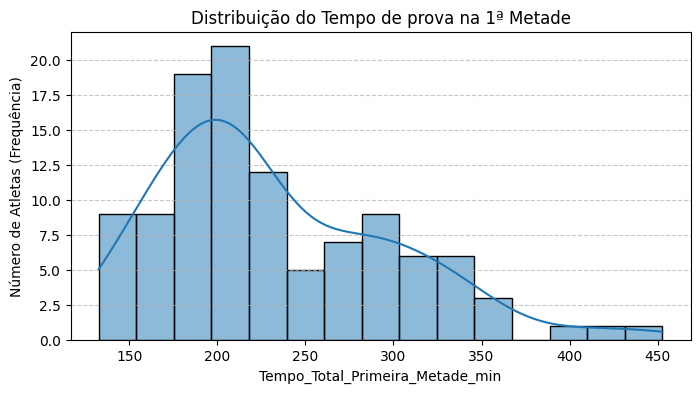

In [55]:
plt.figure(figsize=(8, 4))
sns.histplot(
    data=df_final_completo, x="Tempo_Total_Primeira_Metade_min", kde=True, bins=15
)
plt.title("Distribuição do Tempo de prova na 1ª Metade")
plt.ylabel("Número de Atletas (Frequência)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

<Axes: xlabel='Tempo_Total_Primeira_Metade_min', ylabel='Tempo_Final_min'>

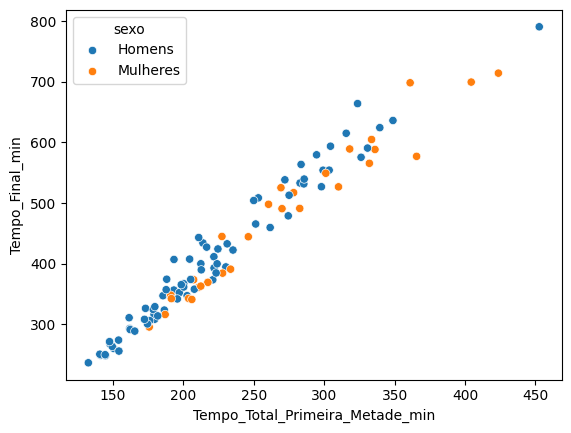

In [56]:
sns.scatterplot(
    data=df_final_completo,
    x="Tempo_Total_Primeira_Metade_min",
    y="Tempo_Final_min",
    hue="sexo",
)


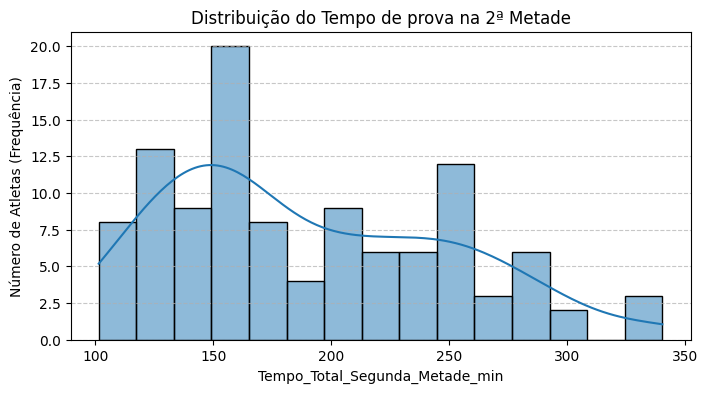

In [54]:
plt.figure(figsize=(8, 4))
sns.histplot(
    data=df_final_completo, x="Tempo_Total_Segunda_Metade_min", kde=True, bins=15
)
plt.title("Distribuição do Tempo de prova na 2ª Metade")
plt.ylabel("Número de Atletas (Frequência)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

<Axes: xlabel='Tempo_Total_Segunda_Metade_min', ylabel='Tempo_Final_min'>

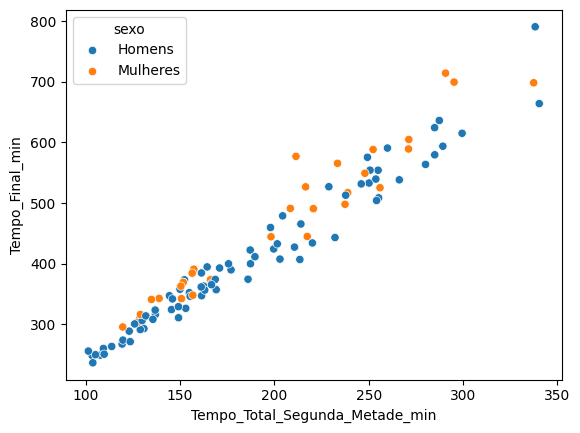

In [57]:
sns.scatterplot(
    data=df_final_completo,
    x="Tempo_Total_Segunda_Metade_min",
    y="Tempo_Final_min",
    hue="sexo",
)

#### Análise Subida vs Descida

In [60]:
df_sobe_desc = df_completo.copy()
df_sobe_desc["Diff_Sob_Desc"] = (
    df_sobe_desc["desnivel_positivo"] + df_sobe_desc["desnivel_negativo"]
)
df_sobe_desc.head()

,Nome Atleta,sexo,faixa_etaria,peso,ano,km_prova,tempo_por_km_seg,ano_mais_antigo,desnivel_positivo,desnivel_negativo,Diff_Sob_Desc
0,André Mapa,Homens,35 a 44,Não informado,2023,1.0,285,2023,13.0,-9.0,4.0
1,André Mapa,Homens,35 a 44,Não informado,2023,2.0,298,2023,88.0,0.0,88.0
2,André Mapa,Homens,35 a 44,Não informado,2023,3.0,295,2023,58.0,0.0,58.0
3,André Mapa,Homens,35 a 44,Não informado,2023,4.0,363,2023,46.0,-81.0,-35.0
4,André Mapa,Homens,35 a 44,Não informado,2023,5.0,357,2023,41.0,-58.0,-17.0


In [61]:
def Sob_Desc(valor):
    if valor > 0:
        return "Subida"
    elif valor < 0:
        return "Descida"
    else:
        return "Plano"


# Aplicando a função ao DataFrame
df_sobe_desc["Sob_Desc"] = df_sobe_desc["Diff_Sob_Desc"].apply(Sob_Desc)
df_sobe_desc.head()

,Nome Atleta,sexo,faixa_etaria,peso,ano,km_prova,tempo_por_km_seg,ano_mais_antigo,desnivel_positivo,desnivel_negativo,Diff_Sob_Desc,Sob_Desc
0,André Mapa,Homens,35 a 44,Não informado,2023,1.0,285,2023,13.0,-9.0,4.0,Subida
1,André Mapa,Homens,35 a 44,Não informado,2023,2.0,298,2023,88.0,0.0,88.0,Subida
2,André Mapa,Homens,35 a 44,Não informado,2023,3.0,295,2023,58.0,0.0,58.0,Subida
3,André Mapa,Homens,35 a 44,Não informado,2023,4.0,363,2023,46.0,-81.0,-35.0,Descida
4,André Mapa,Homens,35 a 44,Não informado,2023,5.0,357,2023,41.0,-58.0,-17.0,Descida
